In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import _cntr as cntr
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 1. Stvaranje umjetnog skupa 2D podataka

In [2]:
class Random2DGaussian():
    def __init__(self, minx=0, maxx=10, miny=0, maxy=10):
        self.mean = (np.random.random_sample() * (maxx - minx) + minx,
                     np.random.random_sample() * (maxy - miny) + miny)
        
        eigvals = (np.random.random_sample(2) * [maxx - minx, maxy - miny] / 5)**2
        
        theta = np.random.random_sample() * 2 * np.pi
        R = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
        
        self.variance = np.dot(np.dot(np.transpose(R), np.diag(eigvals)), R)
        
    def get_sample(self, n):
        return np.random.multivariate_normal(self.mean, self.variance, n)

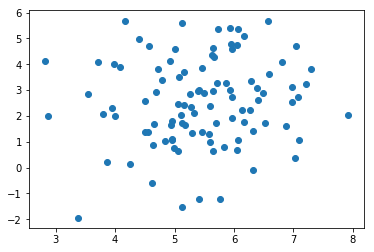

In [3]:
np.random.seed(100)

G=Random2DGaussian()
X=G.get_sample(100)
plt.scatter(X[:,0], X[:,1])
plt.show()

### 2. Učenje binarne logističke regresije gradijentnim spustom

In [4]:
def binlogreg_train(X, Y_, param_niter=100, param_delta=0.6, verbose=False):
    '''
    Argumenti
      X:  podatci, np.array Nx2
      Y_: indeksi razreda, np.array Nx1

    Povratne vrijednosti
      w, b: parametri logističke regresije
    '''
    
    w = np.random.randn(2, 1) # N(0,1) 2 x 1
    b = 0
    
    for i in range(param_niter):
        # klasifikacijske mjere
        scores = np.dot(X, w) + b # N x 1
        
        # vjerojatnosti razreda c1
        probs = np.exp(scores) / (1 + np.exp(scores)) # N x 1
        
        # gubitak
        loss = -np.sum(np.log(probs)) # scalar
        
        # dijagnostički ispis
        if verbose and i % 10 == 0:
            print("iteration {}: loss {}".format(i, loss))
        
        # derivacije gubitka po klasifikacijskim mjerama
        dL_dscores = probs - Y_ # N x 1
        
        N = len(X)
        #gradijenti parametara
        grad_w = np.sum(np.dot(X.transpose(), dL_dscores), axis=1, keepdims=True) / N # D x 1
        grad_b = np.sum(dL_dscores) / N # 1 x 1
        
        #poboljsani parametri
        w += -param_delta * grad_w
        b += -param_delta * grad_b
        
    return w, b

In [5]:
def binlogreg_classify(X, w, b):
    '''
      Argumenti
        X:    podatci, np.array Nx2
        w, b: parametri logističke regresije
    
      Povratne vrijednosti
        probs: vjerojatnosti razreda c1
    '''
    
    # klasifikacijski rezultat
    scores = np.dot(X, w.reshape(-1, 1)) + b # N x 1
    
    # vjerojatnost razreda c1
    probs = np.exp(scores) / (1 + np.exp(scores)) # N x 1
    
    return probs

In [6]:
def sample_gauss_2d(C, N):
    G = Random2DGaussian()
    X = G.get_sample(N)
    Y = np.array([[0]] * N)

    for i in range(1, C):
        G = Random2DGaussian()
        X = np.vstack((X, G.get_sample(N)))
        Y = np.vstack((Y, [[i]] * N))
    
    return X, Y

In [7]:
def get_statistical_data(Y, Y_):
    good = Y[np.where(Y == Y_)]
    bad = Y[np.where(Y != Y_)]
    
    TP = len(good[np.where(good == 1)])
    TN = len(good[np.where(good == 0)])
    FP = len(bad[np.where(bad == 1)])
    FN = len(bad[np.where(bad == 0)])
    
    return TP, TN, FP, FN

def get_accuracy(TP, TN, FP, FN):
    return (1. * TP + TN) / (TP + TN + FP + FN)

def get_recall(TP, FN):
    return (1. * TP) / (TP + FN)

def get_precision(TP, FP):
    return (1. * TP) / (TP + FP)

In [8]:
def eval_perf_binary(Y, Y_):
    TP, TN, FP, FN = get_statistical_data(Y, Y_)
    
    accuracy = get_accuracy(TP, TN, FP, FN)
    recall = get_recall(TP, FN)
    precision = get_precision(TP, FP)
    
    return accuracy, recall, precision

In [9]:
def average_precision_at_index(Yranked, index):
    if index > len(Yranked):
        raise Exception("Index out of range")
        
    Ypredicted = np.zeros(Yranked.shape)
    Ypredicted[index:]=1
    TP, TN, FP, FN = get_statistical_data(Ypredicted, Yranked)
    
    if TP == 0 and FP == 0:
        return 0.0
    return get_precision(TP, FP)
    
def eval_AP(Yranked):
    numerator = np.sum([average_precision_at_index(Yranked,index) * element for index, element in enumerate(Yranked)])
    denominator = np.sum(Yranked)
    return numerator / denominator

In [10]:
np.random.seed(100)

# get the training dataset
X, Y_ = sample_gauss_2d(2, 100)

# train the model
w, b = binlogreg_train(X, Y_)

# evaluate the model on the training dataset
probs = binlogreg_classify(X, w, b)
Y = probs > 0.5

# report performance
accuracy, recall, precision = eval_perf_binary(Y, Y_)
AP = eval_AP(Y_[probs.argsort()])
print('Accuracy: {}\tRecall: {}\tPrecision: {}\tAP: {}'.format(accuracy, recall, precision, AP))

Accuracy: 0.97	Recall: 0.99	Precision: 0.9519230769230769	AP: nan


C:\Users\tzadr\Anaconda2\envs\ipykernel_py3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


### 3. Grafički prikaz rezultata klasifikacije

In [11]:
def myDummyDecision(X):
    scores = X[:,0] + X[:,1] - 5
    return scores.reshape(-1, 1)

In [12]:
def graph_data(X, Y_, Y):
    '''
      X  ... podatci (np.array dimenzija Nx2)
      Y_ ... točni indeksi razreda podataka (Nx1)
      Y  ... predviđeni indeksi razreda podataka (Nx1)
    '''
    
    correctly_classified = X[np.where(Y == Y_)[0]]
    incorrectly_classified = X[np.where(Y != Y_)[0]]
    
    colors = np.array([(y == 0) * 1 + (y == 1) * 0.3 for y in Y_])
    
    color_correct = colors[np.where(Y == Y_)[0]]
    color_incorrect = colors[np.where(Y != Y_)[0]]
    
    plt.scatter(correctly_classified[:,0], correctly_classified[:,1],
                color=np.repeat(color_correct, 3, axis=1), marker='o', edgecolors=(0,0,0), linewidths=0.5)
    plt.scatter(incorrectly_classified[:,0], incorrectly_classified[:,1],
                color=np.repeat(color_incorrect, 3, axis=1), marker='s', edgecolors=(0,0,0), linewidths=0.5)

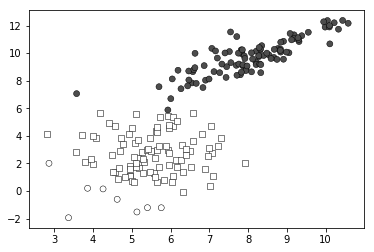

In [13]:
np.random.seed(100)
  
# get the training dataset
X, Y_ = sample_gauss_2d(2, 100)

# get the class predictions
Y = myDummyDecision(X) > 0.5

# graph the data points
graph_data(X, Y_, Y) 

# show the results
plt.show()

### 4. Iscrtavanje funkcije odluke

In [14]:
def graph_surface(fun, rect, offset=0):
    '''
      fun    ... decizijska funkcija (Nx2)->(Nx1)
      rect   ... željena domena prikaza zadana kao:
                 ([x_min,y_min], [x_max,y_max])
      offset ... "nulta" vrijednost decizijske funkcije na koju 
                 je potrebno poravnati središte palete boja;
                 tipično imamo:
                 offset = 0.5 za probabilističke modele 
                    (npr. logistička regresija)
                 offset = 0 za modele koji ne spljošćuju
                    klasifikacijske mjere (npr. SVM)
      width,height ... rezolucija koordinatne mreže
    '''
    
    xmin,ymin = rect[0]
    xmax,ymax = rect[1]
    
    x_range = np.linspace(xmin, xmax, num=1000)
    y_range = np.linspace(ymin, ymax, num=1000)
    
    x,y = np.meshgrid(x_range, y_range)
    grid = np.stack((x.flatten(), y.flatten())).transpose()
    dec = fun(grid)
    
    delta = np.abs(dec - offset).max()
    c = cntr.Cntr(x, y, dec.reshape(x.shape))
    res = c.trace(offset)
    nseg = len(res) // 2
    segments, codes = res[:nseg], res[nseg:]
    plt.plot(segments[0][:,0], segments[0][:,1], color=(0,0,0))
    plt.pcolormesh(x, y, dec.reshape(x.shape), vmin = offset-delta, vmax=offset+delta)

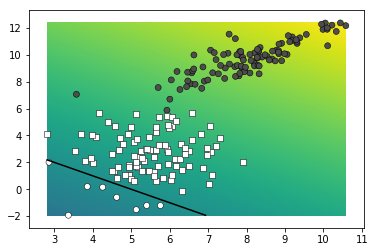

In [15]:
np.random.seed(100)
  
# get the training dataset
X, Y_ = sample_gauss_2d(2, 100)

# get the class predictions
Y = myDummyDecision(X) > 0.5

# graph the surface
bbox=(np.min(X, axis=0), np.max(X, axis=0))
graph_surface(myDummyDecision, bbox, offset=0)

# graph the data points
graph_data(X, Y_, Y)

# show the results
plt.show()

### 5. Grafički prikaz binarne logističke regresije

In [16]:
def binlogreg_decfun(w, b):
    def classify(X):
        return binlogreg_classify(X, w, b)
    return classify

0.97 0.99 0.9519230769230769 0.996576760125


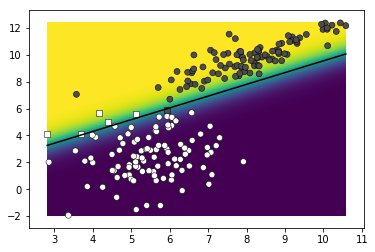

In [17]:
np.random.seed(100)

# instantiate the dataset
X,Y_ = sample_gauss_2d(2, 100)

# train the logistic regression model
w, b = binlogreg_train(X, Y_)

# evaluate the model on the train set
probs = binlogreg_classify(X, w, b)

# recover the predicted classes Y
Y = probs > 0.5
Y = Y.reshape(-1, 1)

# evaluate and print performance measures
acc, recall, precision = eval_perf_binary(Y, Y_)
AP = eval_AP(Y_[probs.flatten().argsort()])
print(acc, recall, precision, AP)

# graph the decision surface
decfun = binlogreg_decfun(w, b)
bbox=(np.min(X, axis=0), np.max(X, axis=0))
graph_surface(decfun, bbox, offset=0.5)

# graph the data points
graph_data(X, Y_, Y)

# show the plot
plt.show()

### 6. Višerazredna logistička regresija

In [18]:
def logreg_train(X, Y_, param_niter=100, param_delta=0.6, verbose=False):
    # eksponencirane klasifikacijske mjere
    # pri računanju softmaksa obratite pažnju
    # na odjeljak 4.1 udžbenika
    # (Deep Learning, Goodfellow et al)!
    scores = ...    # N x C
    expscores = ... # N x C

    # nazivnik sofmaksa
    sumexp = ...    # N x 1

    # logaritmirane vjerojatnosti razreda 
    probs = ...     # N x C
    logprobs = ...  # N x C

    # gubitak
    loss  = ...     # scalar

    # dijagnostički ispis
    if verbose and i % 10 == 0:
        print("iteration {}: loss {}".format(i, loss))

    # derivacije komponenata gubitka po mjerama
    dL_ds = ...     # N x C

    # gradijenti parametara
    grad_W = ...    # C x D (ili D x C)
    grad_b = ...    # C x 1 (ili 1 x C)

    # poboljšani parametri
    W += -param_delta * grad_W
    b += -param_delta * grad_b

In [19]:
# todo: